# SQLAlchemy_Challenge


In [2]:
# Dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from itertools import chain
from pandas import DataFrame
import seaborn as sns
import matplotlib.dates as mdates


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite, this takes SQL database & creates engine to drive database into dataFrame
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table; creating classes based off of the tables avialable in the SQL database.
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [9]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

    

In [10]:

# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe7b2158cd0>,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'tobs': 65.0}

In [12]:
# Using the inspector print column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Display row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe7b6811d90>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set:query db & get the last data point (1st in the dsc order) & find the date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(last_date)

2017-08-23


In [15]:
# convert string date to date format for use with datetime library
last_dt = (dt.datetime.strptime(last_date, "%Y-%m-%d")).date()

In [16]:
# Calculate the date 1 year ago from the last data point in the database
first_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(first_date)

2016-08-23


In [17]:
# Design a query to retrieve the last 12 months of precipitation data.

query = session.query(Measurement).\
            filter(Measurement.date.between(first_date,last_dt)).\
            all()

session.close()

In [18]:
#Select only the date and prcp values.
dates = []
precip = []
for row in query:
    measurement = row
    dates.append(measurement.date)
    precip.append(measurement.prcp)

In [19]:
# Load the query results into a Pandas DataFrame
measurement = pd.DataFrame({"date":dates,
                             "precipitation":precip})
measurement.dropna(inplace = True)
measurement

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2223,2017-08-17,0.13
2225,2017-08-19,0.09
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [20]:
# set the index to the date column and Sort the DataFrame values by date
measurement.set_index('date', inplace = True)
measurement.sort_index(inplace=True)
measurement

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


# Plot the results using  Pandas DataFrame with Matplotlib 

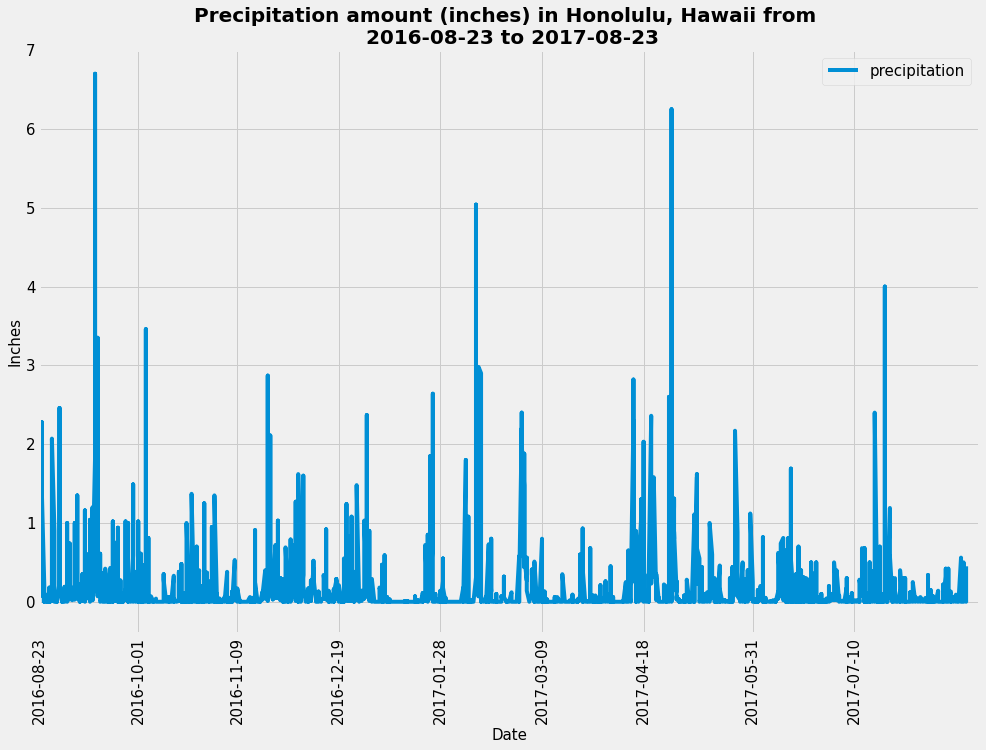

In [21]:
# Set plot and plot the chart
plt.figure(figsize=(15, 10))
plt.plot(measurement.index, measurement['precipitation'])

# Add legned 
plt.legend(['precipitation'], loc="upper right",fontsize=15)
# set x location
xloc = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18','2017-05-31','2017-07-10'] 

# Assign xticks
plt.xticks(xloc, rotation='vertical',fontsize=15)
# Set Labels & Title
plt.xlabel('Date', fontsize=15)
plt.ylabel("Inches",fontsize=15)
plt.title(f"Precipitation amount (inches) in Honolulu, Hawaii from \n {first_date} to {last_dt}",fontsize=20, fontweight = 'bold')
plt.yticks(size=15)

# Asign xlim and ylim
plt.xlim(0,370)
plt.ylim(-0.4,7)


# Save Figure
plt.savefig("Precipitation_Plot.png", bbox_inches = 'tight')
# Show plot
plt.show()

# Exploratory Station Analysis

In [104]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [105]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station).\
                    distinct().\
                    count()

                    
print(f'There are {station_count} stations.')

There are 9 stations.


In [136]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sta = [Station.station, func.count(Measurement.station)]
session.query(*sta).filter(Station.station == Measurement.station).group_by(Station.station).\
                            order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [139]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
selc = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*selc).filter(Measurement.station == sta[0]).all()

[(53.0, 87.0, 73.09795396419437)]

In [140]:
# Choose the station with the highest number of temperature observations.
session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first() # 'USC00519281'
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.tobs).\
            filter(Measurement.date.between(first_date,last_dt),\
                   Measurement.station == 'USC00519281').all()


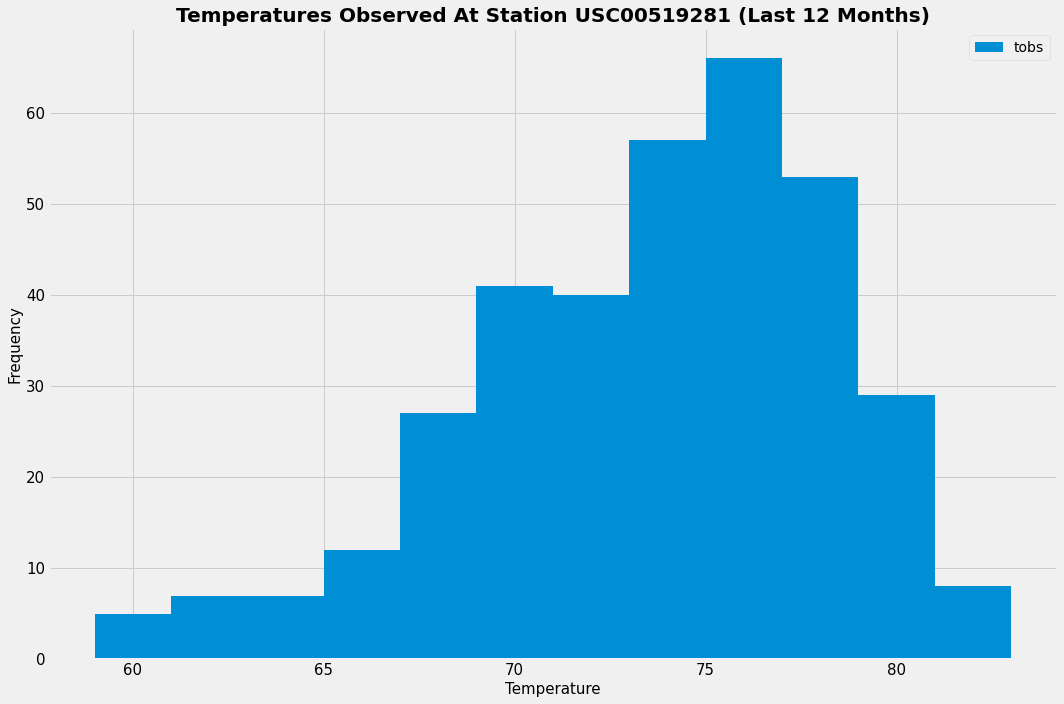

In [143]:
# Plot the results as a histogram
plt.figure(figsize=(15,10))
plt.hist(np.ravel(results), bins=12)
plt.title('Temperatures Observed At Station USC00519281 (Last 12 Months)',fontsize=20, fontweight = 'bold')
plt.xlabel('Temperature',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend(['tobs'], loc = 'upper right')
plt.yticks(size=15)
plt.xticks(size=15)

# Save Figure
plt.savefig("station_Plot.png")
# Show plot
plt.tight_layout()

# Close session

In [144]:
# Close Session
session.close()